### Problem Description

We're provided with data representing traffic sign images, containing 43 different classes of images. We will use LeNet CNN architecture proposed by Yan LeCun to build a neural network capable of classifying these traffic signs. 

### The Approach

The project consists of the following steps:

1. Importing and preprocessing the image data
2. Building and training the CNN
3. Testing the CNN and examining the results

### Importing the Dataset

The data is given not as a bunch of image files, but as .p (pickle) file. Using a special `pickle` library Python will read this data and convert it into dictionary of arrays and integers representing images and labels.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

In [2]:
with open('./traffic-signs-data/train.p', mode = 'rb') as train_data:
    train = pickle.load(train_data)

with open('./traffic-signs-data/valid.p', mode = 'rb') as valid_data:
    valid = pickle.load(valid_data)
    
with open('./traffic-signs-data/test.p', mode = 'rb') as test_data:
    test = pickle.load(test_data)

In [3]:
type(train), train.keys()

(dict, dict_keys(['coords', 'labels', 'features', 'sizes']))

In [4]:
#extracting features and labels from the dictionaries
#and forming train, validatation and test sets
X_train, y_train = train['features'], train['labels']
X_val, y_val = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Data Preprocessing

In order to make the training easier, we'll turn the images into grayscale, and normalize image arraye values between -1 and 1. 

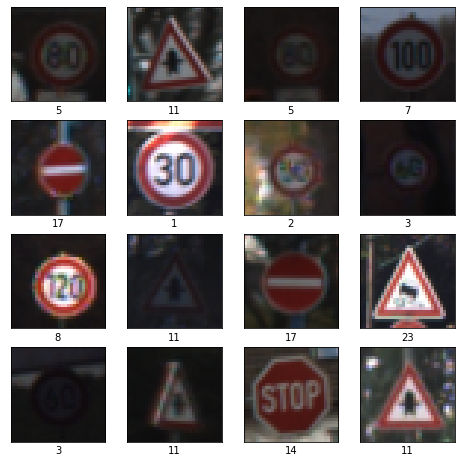

In [5]:
#plotting some of the traffic signs
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    k = random.randrange(len(X_train))
    plt.imshow(X_train[k], cmap=plt.cm.binary)
    plt.xlabel(y_train[k])
plt.show()

In [6]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [7]:
X_train_gray = np.sum(X_train/3, axis = 3, keepdims = True)
X_val_gray = np.sum(X_val/3, axis = 3, keepdims = True)
X_test_gray = np.sum(X_test/3, axis = 3, keepdims = True)

In [8]:
X_train_gray.shape

(34799, 32, 32, 1)

In [9]:
X_train_gray = (X_train_gray - 128)/128
X_val_gray = (X_val_gray - 128)/128
X_test_gray = (X_test_gray - 128)/128

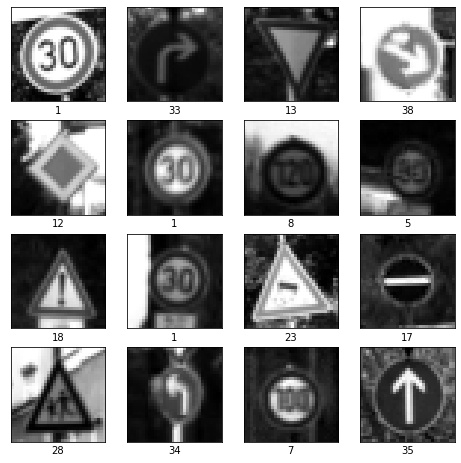

In [10]:
#plotting some of the traffic signs after the preprocessing
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    k = random.randrange(len(X_train))
    plt.imshow(X_train_gray[k].squeeze(), cmap='gray')
    plt.xlabel(y_train[k])
plt.show()

### Training the Model

LeNet is a fairly simple CNN model. It consists of two convolutional layers (each followed by an average pooling layer), connected to three fully connected layers. The output of the last layer classifies the image. 

We use sparse categorical crossentropy as a loss function, and adam optimizer.

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Nadam

Using TensorFlow backend.


In [14]:
#building the CNN
cnn = Sequential()

cnn.add(Conv2D(input_shape = (32, 32, 1), filters = 6,
              kernel_size = (5,5), activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(filters = 16,
              kernel_size = (5,5), activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(MaxPooling2D())

cnn.add(Flatten())

cnn.add(Dense(120, activation = 'relu'))
cnn.add(Dropout(0.4))
cnn.add(Dense(84, activation = 'relu'))
cnn.add(Dropout(0.4))
cnn.add(Dense(43, activation = 'softmax'))

In [15]:
cnn.compile(loss = 'sparse_categorical_crossentropy', 
           optimizer = Nadam(lr = 0.001), metrics = ['accuracy'])

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 10, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)              

In [17]:
history = cnn.fit(X_train_gray, y_train, batch_size=500, epochs = 50,
                 verbose = 0, validation_data = (X_val_gray, y_val))

In [18]:
acc = cnn.evaluate(X_test_gray, y_test)[1]
acc = round(acc*100,2)
print(f'Model accuracy on the test set: {acc}%')

12630/12630 [==============================] - 2s 194us/step
Model accuracy on the test set: 93.81%


We obtain good accuracy on the test set with a quite simple and pretty fast model. Let's examine the changes in loss and accuracy as the training progressed. 

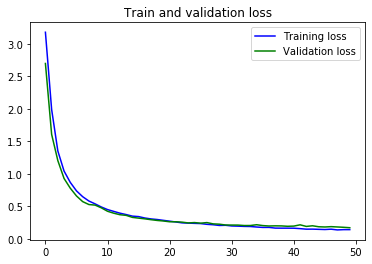

In [19]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(50)

plt.plot(epochs, train_loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
plt.title('Train and validation loss')
plt.legend();

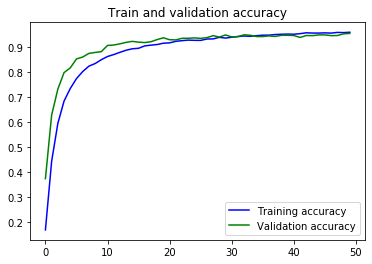

In [20]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, train_acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'g', label = 'Validation accuracy')
plt.title('Train and validation accuracy')
plt.legend();

We see that the model performs quite well on both the training and the validation set, and that there's no overfitting in this set. Let's now draw the confusion matrix.

In [24]:
from sklearn.metrics import confusion_matrix

y_pred = cnn.predict_classes(X_test_gray)

cm = confusion_matrix(y_test, y_pred)

In [32]:
import itertools

# Function to plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    # Plot the confusion matrix as an image
    plt.figure(figsize = (20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 22)
    
    # Tick marks show the labels
    tick_marks = np.arange(43)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add the numbers to the plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")

    # Formatting
    plt.tight_layout()
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.ylabel('True label', size = 18)
    plt.xlabel('\n Predicted label', size = 18)

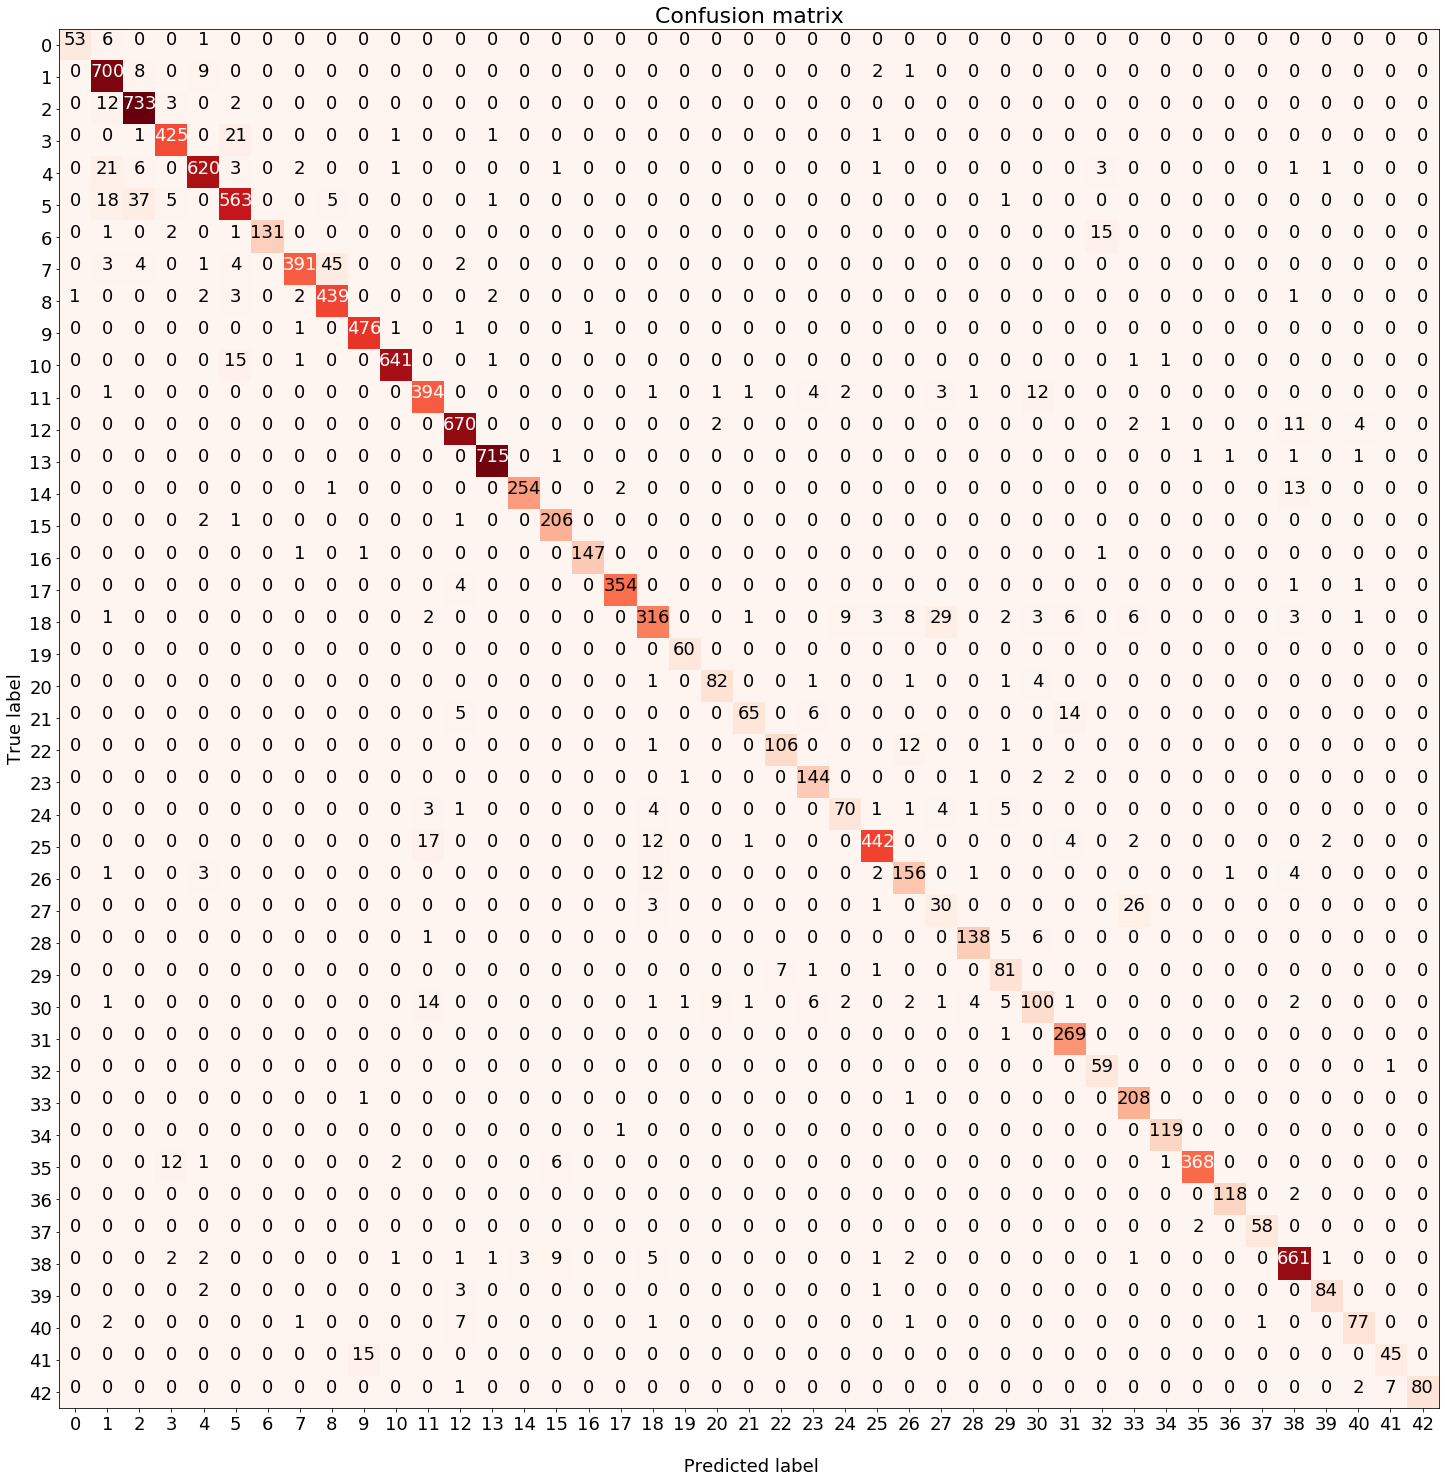

In [33]:
plot_confusion_matrix(cm, list(range(43)))

We see that the model mosly mixed up the class number 18 `General Caution` with the class number 27 `Pedestrians`.

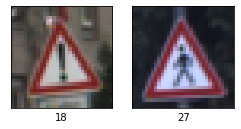

In [54]:
#drawing the mostly confused classes
plt.figure(figsize = (4,4))

plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
idx = np.where(y_train == 18)[0][2]
plt.imshow(X_train[idx], cmap=plt.cm.binary)
plt.xlabel(18)

plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
idx = np.where(y_train == 27)[0][0]
plt.imshow(X_train[idx], cmap=plt.cm.binary)
plt.xlabel(27)



plt.show();

The machine is obviously sometimes confusing the exclamation mark for the little pedestrian.

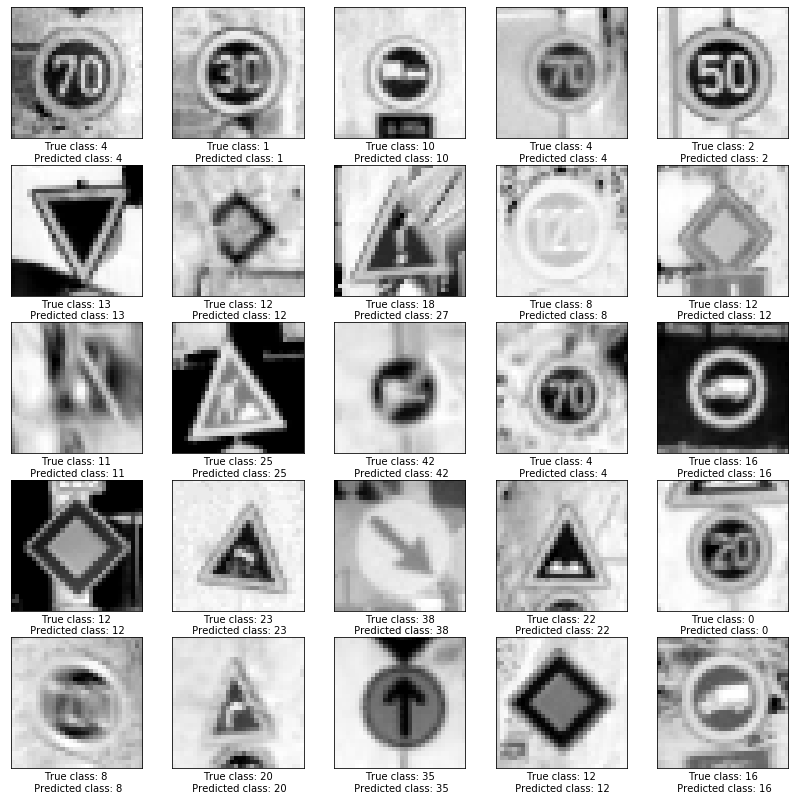

In [68]:
X_test_sq = np.squeeze(X_test_gray, axis = 3)
plt.figure(figsize=(14,14))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    k = random.randrange(len(X_test_sq))
    plt.imshow(X_test_sq[k], cmap=plt.cm.binary)
    plt.xlabel('True class: ' + str(y_test[k]) +
        '\n Predicted class: ' + str(y_pred[k]))
plt.show()

### Conclusions

Using the now classical LeNet architecture we managed to build a simple, yet reliable and fast CNN model to predict the various traffic signs. The most problematic classes are `General Caution` and `Pedestrians` where the exclamation mark sometimes gets mixed up with the pedestran pictogram.